# 分類・回帰（MLP・CNN）

- ランタイム->ランタイムのタイプを変更->GPU
- データのダウンロードに時間がかかるのでとりあえず実行してください

# 分類
ref: https://github.com/pytorch/examples/blob/master/mnist/main.py

- Negative Log-Ligelihood (NLL, 負の対数尤度)
  - $\mathbf{y}$を出力(各クラスの確率のようなベクトル)、$\mathbf{t}$を正解のone_hotベクトルとしたとき、
$$ 
Loss(\mathbf{y}) = -\log(y_i) \quad (ただし y_i=t_i)
$$

  - ref: https://ljvmiranda921.github.io/notebook/2017/08/13/softmax-and-the-negative-log-likelihood/

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output


def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{}]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                loss.item()))


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))



torch.manual_seed(0)

device = torch.device("cuda")

train_kwargs = {'batch_size': 64}
test_kwargs = {'batch_size': 1000}

cuda_kwargs = {'num_workers': 1,
                'pin_memory': True,
                'shuffle': True}
train_kwargs.update(cuda_kwargs)
test_kwargs.update(cuda_kwargs)

transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    # transforms.Resize(56)  # 演習用
    ])

dataset1 = datasets.MNIST('../data', train=True, download=True,
                    transform=transform)
dataset2 = datasets.MNIST('../data', train=False,
                    transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

model = Net().to(device)
optimizer = optim.Adadelta(model.parameters(), lr=1.0)

scheduler = StepLR(optimizer, step_size=1, gamma=0.7)
for epoch in range(1, 4):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()

torch.save(model.state_dict(), "mnist_cnn.pt")

Train Epoch: 1 [0/60000]	Loss: 2.310584
Train Epoch: 1 [6400/60000]	Loss: 0.156014
Train Epoch: 1 [12800/60000]	Loss: 0.094682
Train Epoch: 1 [19200/60000]	Loss: 0.163271
Train Epoch: 1 [25600/60000]	Loss: 0.139334
Train Epoch: 1 [32000/60000]	Loss: 0.018503
Train Epoch: 1 [38400/60000]	Loss: 0.071137
Train Epoch: 1 [44800/60000]	Loss: 0.217014
Train Epoch: 1 [51200/60000]	Loss: 0.066358
Train Epoch: 1 [57600/60000]	Loss: 0.048868

Test set: Average loss: 0.0471, Accuracy: 9827/10000 (98%)

Train Epoch: 2 [0/60000]	Loss: 0.133830
Train Epoch: 2 [6400/60000]	Loss: 0.093764
Train Epoch: 2 [12800/60000]	Loss: 0.067540
Train Epoch: 2 [19200/60000]	Loss: 0.046111
Train Epoch: 2 [25600/60000]	Loss: 0.058343
Train Epoch: 2 [32000/60000]	Loss: 0.065761
Train Epoch: 2 [38400/60000]	Loss: 0.051563
Train Epoch: 2 [44800/60000]	Loss: 0.014348
Train Epoch: 2 [51200/60000]	Loss: 0.018240
Train Epoch: 2 [57600/60000]	Loss: 0.043940

Test set: Average loss: 0.0363, Accuracy: 9875/10000 (99%)

Train Ep

torch.Size([5, 1, 28, 28])


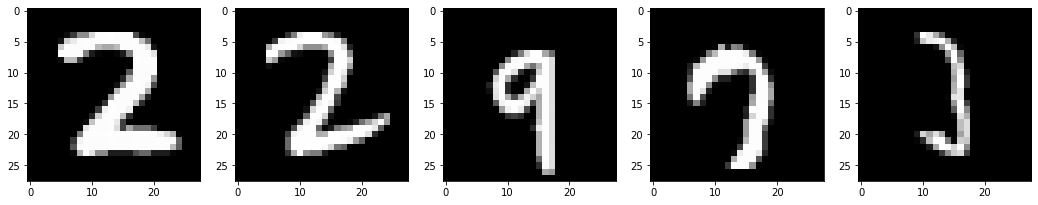

In [2]:
# 可視化
import matplotlib.pyplot as plt
import numpy as np

N=5

data, target = iter(test_loader).next()
data = data[:5].to(device)
print(data.shape)

data_np = data.detach().cpu().numpy()

plt.figure(figsize=(18,18))
for i in range(N):
  plt.subplot(1,N,i+1); plt.imshow(data_np[i].squeeze(), "gray")
plt.show()

In [3]:
# 予測結果の表示

pred = torch.argmax(model(data[:N]), 1)
print(pred)

tensor([2, 2, 9, 7, 2], device='cuda:0')


- 一通り確認出来たら、`transforms.Resize(56)  # 演習用` のコメントアウトを外して、新しい画像サイズで使えるようにモデルを修正してみましょう
  - `Net`クラスの`forward`メソッド内で`print(x.shape)`などとして各層で出力される特徴マップや特徴ベクトルのサイズを確認していき、どこの層のパラメタ数を調整すればよいか考えるとうまく行きます。
  - (一か所変えるだけでも動きます。)
- Conv2Dを通した時に出力される特徴マップのサイズを計算してみるとより理解が深まると思います。
  - ref: [PytorchのConv2Dの詳細](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)

# 回帰

(余力がある人向け)

ref: https://github.com/pytorch/examples/blob/master/regression/main.py

In [4]:
from itertools import count

import torch
import torch.nn.functional as F

POLY_DEGREE = 4
W_target = torch.randn(POLY_DEGREE, 1) * 5
b_target = torch.randn(1) * 5


def make_features(x):
    """Builds features i.e. a matrix with columns [x, x^2, x^3, x^4]."""
    x = x.unsqueeze(1)
    return torch.cat([x ** i for i in range(1, POLY_DEGREE+1)], 1)


def f(x):
    """Approximated function."""
    return x.mm(W_target) + b_target.item()


def poly_desc(W, b):
    """Creates a string description of a polynomial."""
    result = 'y = '
    for i, w in enumerate(W):
        result += '{:+.2f} x^{} '.format(w, i + 1)
    result += '{:+.2f}'.format(b[0])
    return result


def get_batch(batch_size=32):
    """Builds a batch i.e. (x, f(x)) pair."""
    random = torch.randn(batch_size)
    x = make_features(random)
    y = f(x)
    return x, y


# Define model
fc = torch.nn.Linear(W_target.size(0), 1)

for batch_idx in count(1):
    # Get data
    batch_x, batch_y = get_batch()

    # Reset gradients
    fc.zero_grad()

    # Forward pass
    output = F.smooth_l1_loss(fc(batch_x), batch_y)
    loss = output.item()

    # Backward pass
    output.backward()

    # Apply gradients
    for param in fc.parameters():
        param.data.add_(-0.1 * param.grad)

    # Stop criterion
    if loss < 1e-3:
        break

print('Loss: {:.6f} after {} batches'.format(loss, batch_idx))
print('==> Learned function:\t' + poly_desc(fc.weight.view(-1), fc.bias))
print('==> Actual function:\t' + poly_desc(W_target.view(-1), b_target))

Loss: 0.000339 after 332 batches
==> Learned function:	y = +7.08 x^1 -0.02 x^2 +4.09 x^3 +2.65 x^4 +2.69
==> Actual function:	y = +7.06 x^1 -0.06 x^2 +4.11 x^3 +2.66 x^4 +2.70
